# Passo 0 - Setup

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import hdbscan

# Passo 1 - Carregamento e limpeza do dataset

In [121]:
# Dataset retirado de https://raw.githubusercontent.com/adamlamee/CODINGinK12/master/data/stars.csv
# Filtragem de distâncias muito grandes realizadas, corrigindo os outliers de estrelas supergigantes

Primeiramente, serão definidos parâmetros identificando o nome do arquivo e as colunas a serem importadas para as análises.

In [122]:
dataset_file = "stars.csv"

col_color = "ci"
col_mag = "absmag"
col_temp = "temp"
col_lum = "lum"

A seguir, realizamos o carregamento do dataset escolhido, em formato CSV, e uma exibição do diagrama HR esperado, com base nos dados importados, a fim de identificar possíveis outliers e definir parâmetros para a limpeza.

In [123]:
df = pd.read_csv(dataset_file)

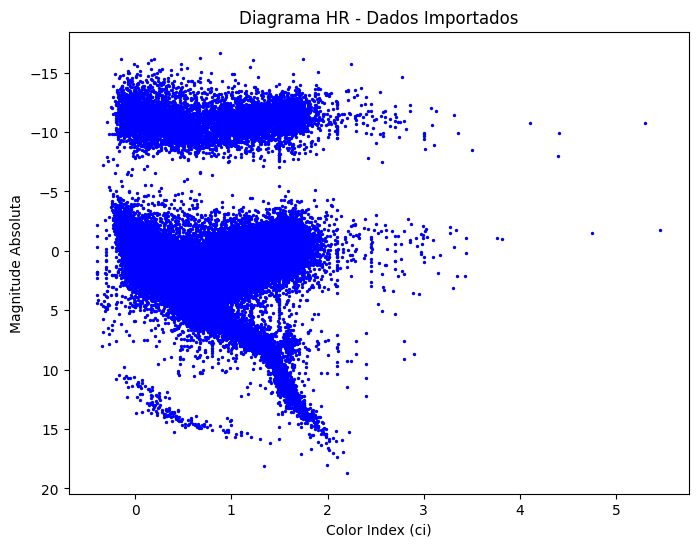

In [124]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados Importados")
plt.show()


No diagrama gerado acima, é possível observar uma grande presença de estrelas na faixa de luminosidade absoluta entre -10 e -15. Fisicamente, esses valores não são esperados, pois estrelas deste tipo são extremamente raras. Isso indica possíveis problemas nos dados importados, como vieses para determinados tipos de estrelas ou parâmetros pouco precisos gerando erros numéricos para parte dos dados.

Para identificar possíveis erros, podemos utilizar o método `.describe()` e analisar os resultados obtidos

In [125]:
df.describe()

,ra,dec,dist,mag,absmag,ci,temp,x,y,z,lum,var_min,var_max
count,119614.000000,119614.000000,119614.000000,119614.000000,119614.000000,117732.000000,117732.000000,119614.000000,119614.000000,119614.000000,1.196140e+05,16991.000000,16991.000000
mean,12.095243,-1.985101,8764.801178,8.429685,0.992129,0.711495,6182.806403,-234.845474,-39.569343,-231.897239,3.544691e+05,9.501848,9.259359
std,6.887589,40.965885,27879.567299,1.427732,4.351890,0.493207,2063.029405,15178.258403,17237.818362,18068.210978,3.333300e+06,1.781001,1.742210
min,0.000000,-89.782428,0.000000,-26.700000,-16.680000,-0.400000,1499.338347,-99950.391270,-99979.246190,-99964.982270,1.230000e-06,-1.333000,-1.523000
25%,6.217463,-36.420663,115.074800,7.650000,0.139000,0.348000,4551.904315,-89.020936,-91.173028,-107.538313,4.746790e+00,8.526000,8.243500
50%,12.127568,-1.639570,213.675200,8.460000,1.495000,0.616000,5905.594297,-1.044429,-1.241516,-3.410872,2.197860e+01,9.849000,9.646000
75%,18.116667,31.519006,390.625000,9.170000,3.159000,1.083000,7169.831570,86.267843,91.846196,94.974160,7.663021e+01,10.707000,10.492000
max,23.998594,89.569427,100000.000000,21.000000,19.629000,5.460000,21707.421710,99982.372690,99996.065510,99862.513670,4.092607e+08,14.902000,13.702000


O primeiro erro notável é em relação às distâncias. O valor máximo para elas está extremamante alto, e medidas astronômicas à tais distâncias podem ser extremamente imprecisas, por possíveis efeitos de nuvens de poeira, erros de fotometria, entre outros. Portanto, a primeira limpeza será a remoção de estrelas com distância acima de 5000.

In [126]:
df = df[df["dist"] < 5000] # Correção de distância, para evitar outliers absurdos

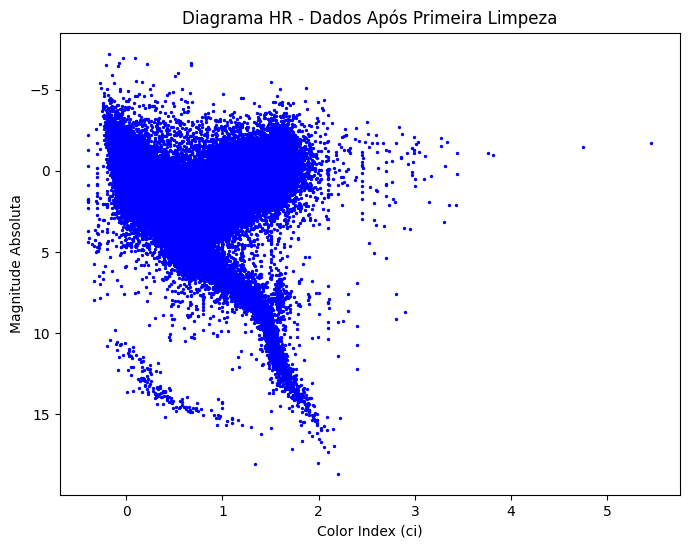

In [127]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados Após Primeira Limpeza")
plt.show()


Agora, observa-se que, em geral, os dados estão mais condizentes com a interpretação física, pois não há uma quantidade massiva de estrelas na faixa de maior luminosidade, e as proporções de cada região parecem estar adequadas. Porém, ainda é possível observar certos outliers, especialmente em relação ao Color Index.

A seguir, são implementados os seguintes filtros:
- Color Index: entre -0.5 e 2.5
- Magnitude Absoluta: entre -15 e 20
- Temperatura: entre 2000 K e 50000 K
- Luminosidade: acima de 0 

Além disso, valores extremos como $-\infty$ e $\infty$ serão substituídos por NaN, e os valores NaN serão removidos do dataframe.

In [128]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[col_color, col_mag, col_temp, col_lum])

df = df[df[col_color].between(-0.5, 2.5)]
df = df[df[col_mag].between(-15, 20)]
df = df[df[col_temp].between(2000, 50000)]
df = df[df[col_lum] > 0]

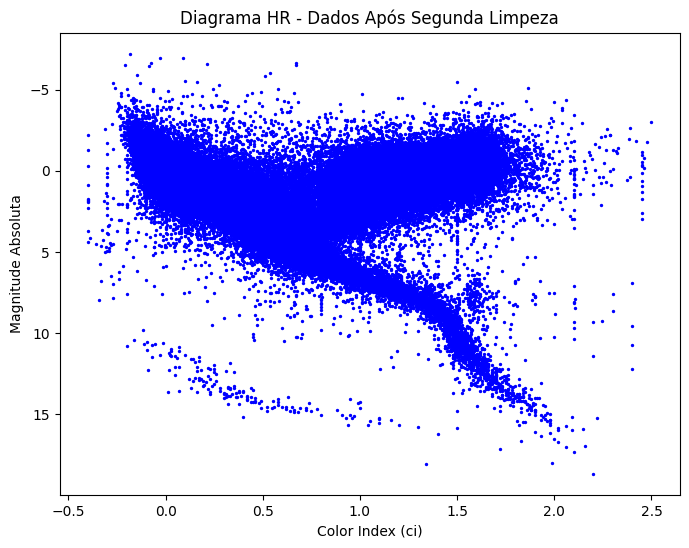

In [129]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados Após Segunda Limpeza")
plt.show()


Abaixo, serão calculados o raio estimado para cada estrela, e uma "flag", indicando a faixa de magnitude e cor na qual as estrelas provavelmente são do tipo "anã branca".

In [130]:
# R/Rsun = sqrt(L / (T/Tsun)^4)
Tsun = 5772
df["radius_est"] = np.sqrt(df[col_lum] / ((df[col_temp] / Tsun) ** 4))

# Identificação de anãs brancas
df["white_dwarf_flag"] = (
    (df[col_mag] > 10) &
    (df[col_color] < 0.5)
)

Por fim, antes das análises de clusterização, será selecionada uma amostra do dataframe limpo, considerando 50000 estrelas.

In [131]:
df = df.sample(50000, random_state=56)

Com isso, foram selecioandas as estrelas apresentadas no diagrama HR abaixo para as análises.

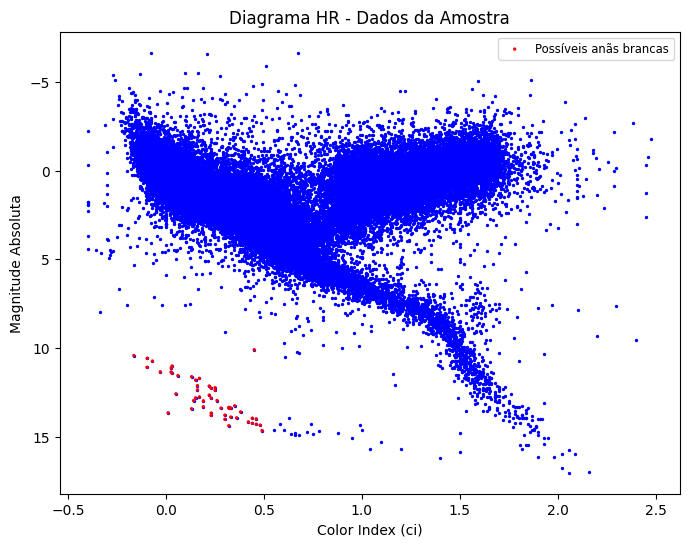

In [132]:
plt.figure(figsize=(8, 6))

plt.scatter(df[col_color], df[col_mag],
                c='blue',
                s=2)

wd = df[df["white_dwarf_flag"]]
plt.scatter(wd[col_color], wd[col_mag],
            edgecolors="red",
            facecolors="none",
            s=2,
            label="Possíveis anãs brancas")

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR - Dados da Amostra")
plt.legend(markerscale=1, fontsize="small", loc="best")
plt.show()


# Teste HDBSCAN

C:\Users\Marcelo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


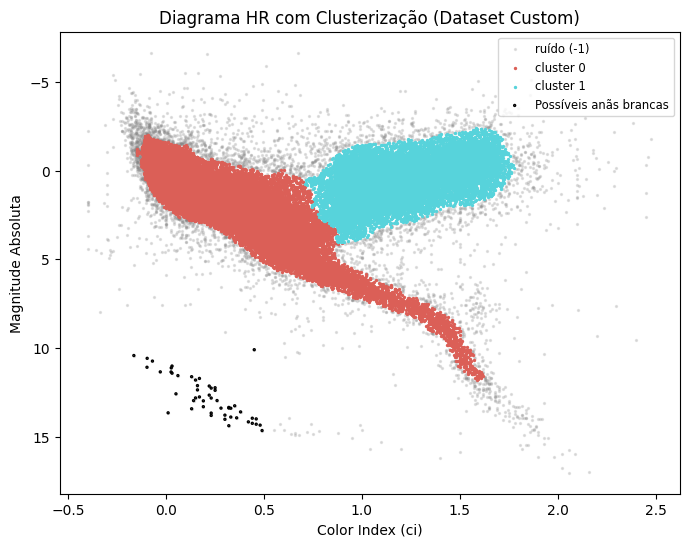

In [133]:
features = df[[col_mag, col_color, col_temp]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

clusterer = hdbscan.HDBSCAN(min_cluster_size=40)
df["cluster"] = clusterer.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))

clusters_valid = [c for c in df["cluster"].unique() if c != -1]

palette = sns.color_palette("hls", len(clusters_valid))
cluster_colors = {c: palette[i] for i, c in enumerate(clusters_valid)}
cluster_colors[-1] = (0.5, 0.5, 0.5)

noise = df[df["cluster"] == -1]
plt.scatter(noise[col_color], noise[col_mag],
            c=[cluster_colors[-1]],
            alpha=0.2, s=2, label="ruído (-1)")

for c in clusters_valid:
    subset = df[df["cluster"] == c]
    plt.scatter(subset[col_color], subset[col_mag],
                c=[cluster_colors[c]],
                s=2, alpha=1, label=f"cluster {c}")

wd = df[df["white_dwarf_flag"]]
plt.scatter(wd[col_color], wd[col_mag],
            edgecolors="black",
            facecolors="none",
            s=2,
            label="Possíveis anãs brancas")

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR com Clusterização (Dataset Custom)")
plt.legend(markerscale=1, fontsize="small", loc="best")
plt.show()


In [134]:
df.describe()

,ra,dec,dist,mag,absmag,ci,temp,x,y,z,lum,var_min,var_max,radius_est,cluster
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,6055.000000,6055.000000,50000.000000,50000.000000
mean,12.081509,-2.111413,248.126858,8.319334,2.009821,0.696895,6199.364794,-0.276805,0.938596,-6.496720,65.916692,9.322384,9.120092,6.956681,0.260900
std,6.908447,40.923593,190.343543,1.360531,2.274356,0.472333,2011.740908,166.128447,179.904361,194.400169,395.678464,1.818118,1.797917,10.140290,0.570927
min,0.000060,-89.308548,1.295900,-1.440000,-6.633000,-0.400000,2741.416504,-975.513096,-956.237137,-952.790124,0.000014,-1.333000,-1.523000,0.005814,-1.000000
25%,6.153703,-36.449695,110.011000,7.590000,0.523000,0.357000,4600.895299,-78.430770,-79.930582,-95.223533,4.381270,8.274000,8.024000,1.599678,0.000000
50%,12.145741,-2.035929,196.463700,8.390000,1.701000,0.602000,5959.723557,-0.105591,-1.489701,-4.077279,18.180256,9.758000,9.581000,2.750824,0.000000
75%,18.134735,31.110989,331.125800,9.080000,3.246000,1.061000,7117.822147,78.415228,80.578747,84.560832,53.802196,10.592500,10.416500,8.816753,1.000000
max,23.998594,89.264109,990.099000,17.820000,17.013000,2.479000,21707.421710,977.365049,966.239750,954.983647,39192.232250,14.245000,12.612000,294.588513,1.000000
